# CS 445 Final Project: Video/Image Upsamling

### Setup

In [1]:
datadir = "./" 

utilfn = datadir + "utils.py"
imagesfn = datadir + "images"

In [2]:
import ffmpeg
import cv2
import numpy as np
import os
import numpy.linalg as la
import utils
%matplotlib inline
from matplotlib import pyplot as plt

from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

# Image Upsamling

### Read input image

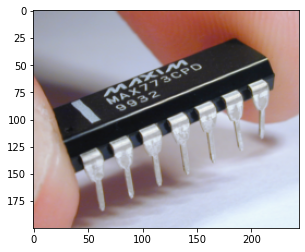

In [1068]:
input_img_location = imagesfn + '/chip_input.png'
im1 = cv2.cvtColor(cv2.imread(input_img_location), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(im1)

## 1. Initial Up-Sample using fast bicubic interpolation

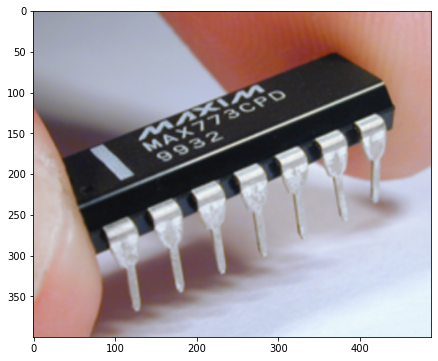

In [1069]:
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)

## 2. Feedback-control upsamling

In [653]:

# sigma = 2
# ksize = int(np.ceil(sigma)*6+1)
# fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
# fil = fil*np.transpose(fil)

# full_size_fil = np.zeros((400, 488))
# x_start = int((full_size_fil.shape[0] - fil.shape[0]) / 2)
# y_start = int((full_size_fil.shape[1] - fil.shape[1]) / 2)
# full_size_fil[x_start:x_start + fil.shape[0], y_start:y_start + fil.shape[1]] = fil

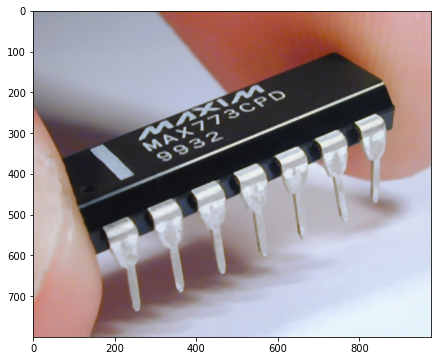

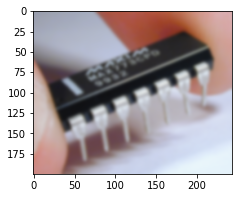

In [778]:
## test if method works using kernel we give
expect_loc = imagesfn + "/chip_10iter_s2.0_deconv0.03.png"
expect_im = cv2.cvtColor(cv2.imread(expect_loc), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure(figsize=(8, 6))
plt.imshow(expect_im)

# blur and down sample expect image using known kernal

sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

down_sample_result = cv2.resize(cv2.filter2D(H, -1, fil), None, fx=0.5, fy=0.5)
plt.figure(figsize=(4, 3))
plt.imshow(down_sample_result)

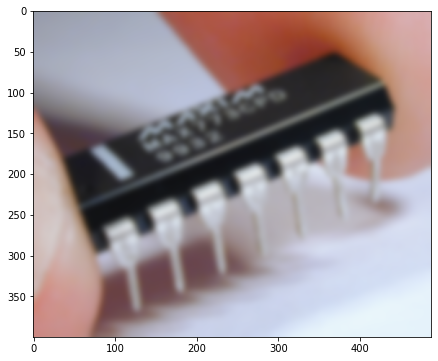

In [779]:
im1 = down_sample_result.copy()
bicubic_im1 = cv2.resize(im1, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(8, 6))
plt.imshow(bicubic_im1)

## Deconvolution
***
### Compute image gradient density 

In [1070]:
def compute_gradient(img):
#     f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
#     f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T
    f1 = np.array([[-1], [0], [1]])
    f2 = np.array([[-1, 0, 1]])
    vert_gradient = cv2.filter2D(img, -1, f1)
    horz_gradient = cv2.filter2D(img, -1, f2)
    gradient = np.sqrt(np.square(vert_gradient) + np.square(horz_gradient))
    return gradient

In [1071]:
gradient = compute_gradient(im1)
gradR = gradient[:,:,0]
gradG = gradient[:,:,1]
gradB = gradient[:,:,2]

In [1072]:
gradR_norm = cv2.normalize(gradR, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
gradR_norm = gradR_norm.astype(np.uint8)

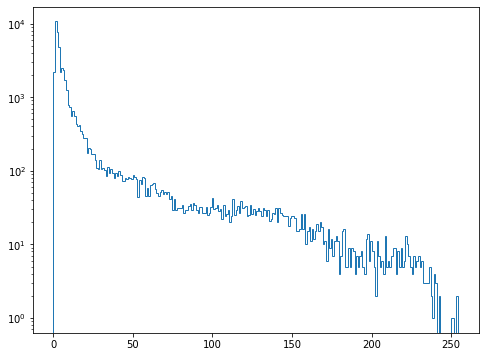

In [1074]:
flatten_gradR = gradR_norm.flatten()
plt.figure(figsize=(8, 6))
counts, bins, bars = plt.hist(r, log=True, bins=256,range=(0,255),facecolor="r", histtype = 'step')
plt.show()

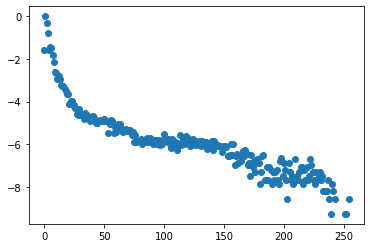

In [1075]:
df = pd.Series(flatten_gradR).value_counts().reset_index()
df.columns = ['val', 'count']
val = np.array(df['val'])
log_count = np.log(df['count'] / df['count'].max())
plt.scatter(val, log_count)
plt.show()

In [1076]:
my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]

[  0.          24.69173479 254.        ]


In [1077]:
def piecewise(x, k, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x), lambda x: -1 * (a * (x ** 2) + b)])

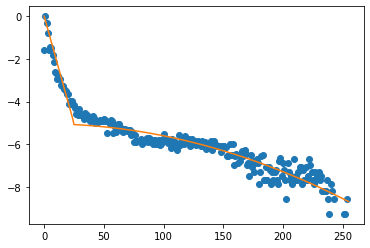

In [1078]:
p , e = optimize.curve_fit(piecewise, val, log_count)
xd = np.linspace(0, 255, len(df['count']))
plt.plot(val,  log_count, "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [1079]:
k, a, b = p[0], p[1], p[2]
print("k={:.10f}, a={:.10f}, b={:.10f}: ".format(k, a, b))

k=0.2010861286, a=0.0000560827, b=5.0471806594: 


In [1080]:
def phi(x, l_t, k, a, b):
    if abs(x) <= l_t:
        return -k * abs(x)
    return -(a * x**2 + b)

In [1081]:
def calculate_phi(gradient):
    l_t_arr = np.zeros(3)
    k_arr = np.zeros(3)
    a_arr = np.zeros(3)
    b_arr = np.zeros(3)
    for i in range(3):
        grad = gradient[:,:,i]
        grad_norm = cv2.normalize(grad, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
        grad_norm = grad_norm.astype(np.uint8)
        flatten_grad = grad_norm.flatten()
        df = pd.Series(flatten_grad).value_counts().reset_index()
        df.columns = ['val', 'count']
        val = np.array(df['val'])
        log_count = np.log(df['count'] / df['count'].max())
        my_pwlf = pwlf.PiecewiseLinFit(val, log_count)
        breaks = my_pwlf.fit(2)
        l_t = breaks[1]
        p , e = optimize.curve_fit(piecewise, val, log_count)
        l_t_arr[i] = l_t
        k_arr[i], a_arr[i], b_arr[i] = p[0], p[1], p[2]
    return l_t_arr, k_arr, a_arr, b_arr
        

In [1082]:
l_t_arr, k_arr, a_arr, b_arr = calculate_phi(gradient)

### Minimize Energy function

In [921]:
# # use flice version
# H_prime = bicubic_im1.copy()

# sigma = 2
# ksize = int(np.ceil(sigma)*6+1)
# fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
# fil = fil*np.transpose(fil)

# s1 = np.array(H_prime.shape[:2])
# s2 = np.array(fil.shape)
# size = s1 + s2 - 1

# fsize = 2 ** np.ceil(np.log2(size)).astype(int)
# fslice = tuple([slice(0, int(sz)) for sz in size])

# # only compute filter and H_prime fft once
# f_fft = np.fft.fft2(fil , fsize)
# f_fft = f_fft[:,:,np.newaxis]
# H_prime_fft = np.fft.fftn(H_prime, (fsize[0],fsize[1], 3))



In [1083]:
# transform filter to have same size as image version
sigma = 2
ksize = int(np.ceil(sigma)*6+1)
fil = cv2.getGaussianKernel(ksize, sigma) # 1D kernel
fil = fil*np.transpose(fil)

full_size_fil = np.zeros((400, 488))
x_start = int((full_size_fil.shape[0] - fil.shape[0]) / 2)
y_start = int((full_size_fil.shape[1] - fil.shape[1]) / 2)
full_size_fil[x_start:x_start + fil.shape[0], y_start:y_start + fil.shape[1]] = fil
fil = full_size_fil.copy()

In [1084]:
H_prime = bicubic_im1.copy()
f_fft = np.fft.fft2(fil)
f_fft = f_fft[:,:,np.newaxis]
H_prime_fft = np.fft.fftn(H_prime)

In [1049]:
H_prime_fft = np.fft.fftn(H_prime)

In [1085]:
H = H_prime.copy()  # assume gaussian filter does nothing
f1 = np.array([[-1], [0], [1]])
f2 = np.array([[-1, 0, 1]])
H_x_gradient = cv2.filter2D(H, -1, f1)
H_y_gradient = cv2.filter2D(H, -1, f2)

lambda_1 = 0.3
lambda_2 = 20


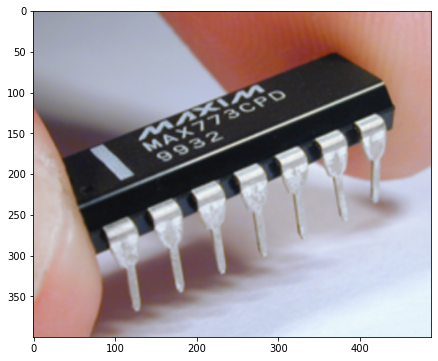

In [1086]:
plt.figure(figsize=(8, 6))
plt.imshow(H)

- $\mu$ Step: fix$H$to optimize $\mu$
$$ E(\mu) = \lambda_1\parallel \Phi(\mu_x) \parallel_1 + \ \lambda_2\parallel \mu_x - \partial_x H \parallel_2^{2}$$
***
$$ \partial_x H \geq l_t : E(\mu) = \lambda_1| -k|\mu_x| | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
$$ \partial_x H < l_t : E(\mu) = \lambda_1| -(a \mu_x^2 + b) | + \lambda_2 (\mu_x - \partial_x H)^2$$
***
By solving $\partial E(\mu)/ \partial \mu = 0$, we have
$$ \partial H \geq l_t : \mu = \frac{2 \lambda_2 \partial H \pm \lambda_1 k}{2 \lambda_2}$$
***
$$ \partial H < l_t : \mu = \frac{2 \lambda_2 \partial H}{2 \lambda_1 a + 2 \lambda_2}$$

In [1087]:
# 𝜇 step
def mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient):
    mu_x = np.zeros(H_x_gradient.shape)
    mu_y = np.zeros(H_y_gradient.shape)
    height,width = H_x_gradient.shape[:2]

    for c in range(3):
        l_t = l_t_arr[c]
        # since phi is calculated between 0 and 255
        k = k_arr[c] * 255
        a = a_arr[c] * (255**2)
        b = b_arr[c]
        for i in range(height):
            for j in range(width):
                curr_x_grad = H_x_gradient[i, j, c]
                curr_y_grad = H_y_gradient[i, j, c]
                
                if abs(curr_x_grad) >= l_t:
                    if curr_x_grad > 0:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_x[i,j,c] = ((2 * lambda_2 * curr_x_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_x[i,j,c] = (2 * lambda_2 * curr_x_grad) / (2 * lambda_1 * a + 2 * lambda_2)
                
                if abs(curr_y_grad) >= l_t:
                    if curr_y_grad > 0:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) - lambda_1 * k) / (2 * lambda_2)
                    else:
                        mu_y[i,j,c] = ((2 * lambda_2 * curr_y_grad) + lambda_1 * k) / (2 * lambda_2)
                else:
                    mu_y[i,j,c] = (2 * lambda_2 * curr_y_grad) / (2 * lambda_1 * a + 2 * lambda_2)
    
    return mu_x, mu_y
                

In [1088]:
mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)

In [1089]:
H_x_grad_fft = np.fft.fftn(H_x_gradient)
H_y_grad_fft = np.fft.fftn(H_y_gradient)
mu_x_fft = np.fft.fftn(mu_x)
mu_y_fft = np.fft.fftn(mu_y)

In [1090]:
upper_adding = lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft
lower_adding = lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft

In [1091]:
clip_upper = np.clip(upper_adding, 0, 0.05)
clip_lower = np.clip(lower_adding, 0, 0.05)

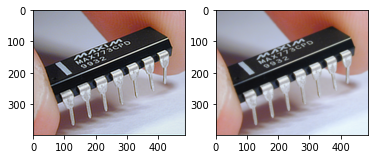

In [1092]:
test = np.fft.ifftn(((np.conj(f_fft) * H_prime_fft) +clip_upper) / ((np.conj(f_fft) * f_fft) +clip_lower))
test = np.clip(np.real(test), 0, 1)
# mid_x = int(test.shape[0] / 2)
# mid_y = int(test.shape[1] / 2)
# shift_result = np.zeros(test.shape)
# shift_result[:mid_x, :mid_y, :] = test[mid_x:, mid_y:, :]
# shift_result[mid_x:, :mid_y, :] = test[:mid_x, mid_y:, :]
# shift_result[:mid_x, mid_y:, :] = test[mid_x:, :mid_y, :]
# shift_result[mid_x:, mid_y:, :] = test[:mid_x, :mid_y, :]
shift_result = np.fft.fftshift(test,(0,1))


plt.subplot(1,2,1)
plt.imshow(shift_result)
plt.subplot(1,2,2)
plt.imshow(H_prime)
plt.show()

- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

In [1039]:
# def H_optimize(f_fft, H_prime_fft, fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y):
#     H_x_grad_fft = np.fft.fftn(H_x_gradient, (fsize[0],fsize[1], 3))
#     H_y_grad_fft = np.fft.fftn(H_y_gradient, (fsize[0],fsize[1], 3))
#     mu_x_fft = np.fft.fftn(mu_x, (fsize[0],fsize[1], 3))
#     mu_y_fft = np.fft.fftn(mu_y, (fsize[0],fsize[1], 3))
    
#     upper_adding = lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft
#     lower_adding = lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft
#     clip_upper = np.clip(upper_adding, 0.001, 0.1)
#     clip_lower = np.clip(lower_adding, 0.001, 0.1)
    
#     H_star_fft = ((np.conj(f_fft) * H_prime_fft) +clip_upper) / ((np.conj(f_fft) * f_fft) +clip_lower)
#     H_star = np.fft.ifftn(H_star_fft)[fslice]
#     H_star = np.clip(np.real(H_star),0,1)
    
#     x_pad = int((H_star.shape[0] - mu_x.shape[0]) / 2)
#     y_pad = int((H_star.shape[1] - mu_x.shape[1]) / 2)
#     H_star = H_star[x_pad:-x_pad, y_pad:-y_pad,:]
#     return H_star

In [ ]:
# H_star = H_optimize(f_fft, H_prime_fft,fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

In [902]:
# for i in range(4):
#     lambda_2 *= 3
#     H = H_star.copy()
#     H_x_gradient = cv2.filter2D(H, -1, f1)
#     H_y_gradient = cv2.filter2D(H, -1, f2)
#     mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
#     H_star = H_optimize(f_fft, H_prime_fft,fsize, fslice, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

In [1093]:
def H_optimize(f_fft, H_prime_fft, lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y):
    H_x_grad_fft = np.fft.fftn(H_x_gradient)
    H_y_grad_fft = np.fft.fftn(H_y_gradient)
    mu_x_fft = np.fft.fftn(mu_x)
    mu_y_fft = np.fft.fftn(mu_y)
    
    upper_adding = lambda_2 * np.conj(H_x_grad_fft) * mu_x_fft + lambda_2 * np.conj(H_y_grad_fft) * mu_y_fft
    lower_adding = lambda_2 * np.conj(H_x_grad_fft) * H_x_grad_fft + lambda_2 * np.conj(H_y_grad_fft) * H_y_grad_fft
    clip_upper = np.clip(upper_adding, 0, 0.05)
    clip_lower = np.clip(lower_adding, 0, 0.05)
    
    H_star_fft = ((np.conj(f_fft) * H_prime_fft) +clip_upper) / ((np.conj(f_fft) * f_fft) +clip_lower)
    H_star = np.fft.ifftn(H_star_fft)[fslice]
    H_star = np.clip(np.real(H_star),0,1)
    
    shift_result = np.fft.fftshift(H_star,(0,1))
    return shift_result

In [1094]:
H_star = H_optimize(f_fft, H_prime_fft,lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

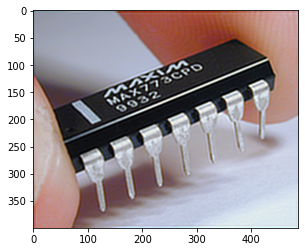

In [1095]:
plt.figure()
plt.imshow(H_star)

In [1096]:
for i in range(4):
    lambda_2 *= 3
    H = H_star.copy()
    H_x_gradient = cv2.filter2D(H, -1, f1)
    H_y_gradient = cv2.filter2D(H, -1, f2)
    mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
    H_star = H_optimize(f_fft, H_prime_fft,lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)

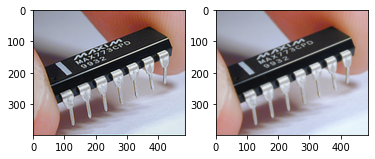

In [1097]:
plt.subplot(1,2,1)
plt.imshow(H_star)
plt.subplot(1,2,2)
plt.imshow(H_prime)
plt.show()

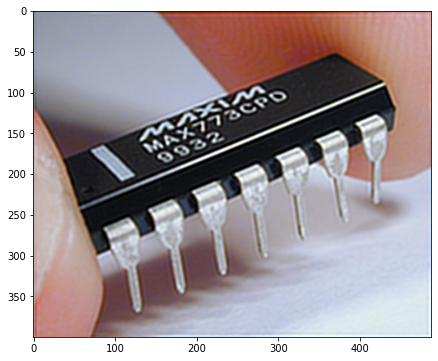

In [1098]:
plt.figure(figsize=(8, 6))
plt.imshow(H_star)

## Re-convolution

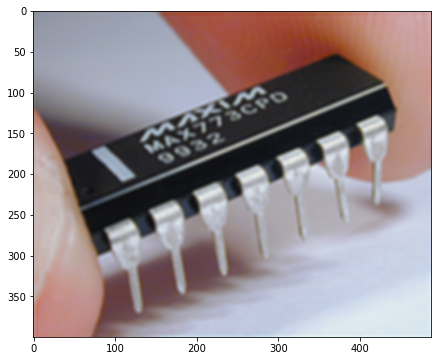

In [1099]:
# should be close to bicubic iterpolated image(original h prime)
refil_im = cv2.filter2D(H_star, -1, fil)
plt.figure(figsize=(8, 6))
plt.imshow(refil_im)

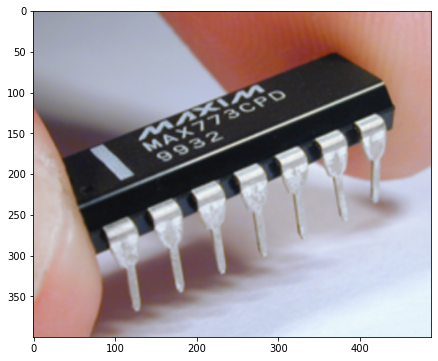

In [1100]:
plt.figure(figsize=(8, 6))
plt.imshow(H_prime)

In [1047]:
H_prime = refil_im.copy()

## Pixel Substitution

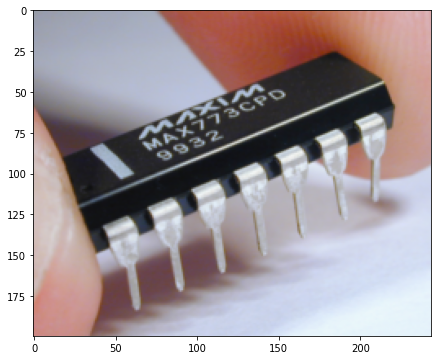

In [1006]:
# substitute im1 pixel to h prime
plt.figure(figsize=(8, 6))
plt.imshow(im1)

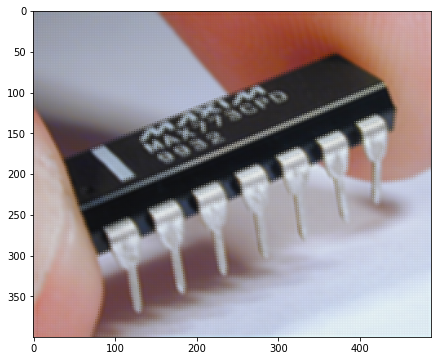

In [1048]:
n = 2
for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        H_prime[n * i, n * j, :] = im1[i,j,:]

plt.figure(figsize=(8, 6))
plt.imshow(H_prime)      

## Loop

In [1016]:
H_prime = bicubic_im1.copy()

loop_iteration = 2

for i in range(loop_iteration):
    f_fft = np.fft.fft2(fil)
    f_fft = f_fft[:,:,np.newaxis]
    H_prime_fft = np.fft.fftn(H_prime)
    
    H = H_prime.copy()  # assume gaussian filter does nothing

    lambda_1 = 0.3
    lambda_2 = 20
    
    for j in range(2):
        H_x_gradient = cv2.filter2D(H, -1, f1)
        H_y_gradient = cv2.filter2D(H, -1, f2)
        mu_x, mu_y = mu_optimize(l_t_arr, k_arr, a_arr, b_arr, lambda_1, lambda_2, H_x_gradient, H_y_gradient)
        H_star = H_optimize(f_fft, H_prime_fft,lambda_2, H_x_gradient, H_y_gradient, mu_x, mu_y)
        lambda_2 *= 3
        H = H_star.copy()
    
    refil_im = cv2.filter2D(H_star, -1, fil)
    H_prime = refil_im.copy()
    
    n = 2
    for k in range(im1.shape[0]):
        for l in range(im1.shape[1]):
            H_prime[n * k + 1, n * l + 1, :] = im1[i,j,:]
    print('one iteration finished')

one iteration finished
one iteration finished


## 3. Final Output

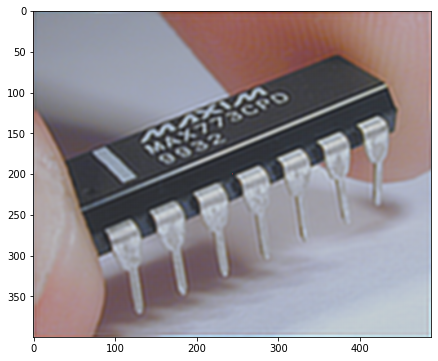

In [1017]:
plt.figure(figsize=(8, 6))
plt.imshow(H_star)   

# Video Upsamling